In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, \
    cross_validate, cross_val_predict, GridSearchCV

from utils import *

In [6]:
PATH = 'limonene_data.csv'

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X-Mh', 'B-Lm', '2X-Ll', 'A-Mm', 'B-Ll', 'A-Mh', '2X-Lm',
       'A-Hl', '2X-Hh', 'B-Ml', 'B-Mm', '2X-Lh', 'B-Mh', '2X-Hl', 'B-Hl',
       '2X-Ml', 'B-Hm', 'B-Lh', 'B-Hh', 'A-Ll', 'A-Hm', '2X-Mm', 'A-Hh',
       'A-Ml', 'A-Lm',  'A-Lh', '2X-Hm']

DBTL_B = ['BL-Mm', 'BL-Mh', 'BL-Ml']

Read orinal dataset and transform it for analysis

In [7]:
df = read_data(PATH)
print(f'Original data shape: {df.shape}')

data = transform_data(df)
print(f'Processed data shape: {data.shape}')

# DBTL 1st cycle 
data_A = data[data.index.isin(DBTL_A)]
# DBTL 2nd cycle
data_b = data[data.index.isin(DBTL_B)] 

Original data shape: (330, 3)
Processed data shape: (30, 10)


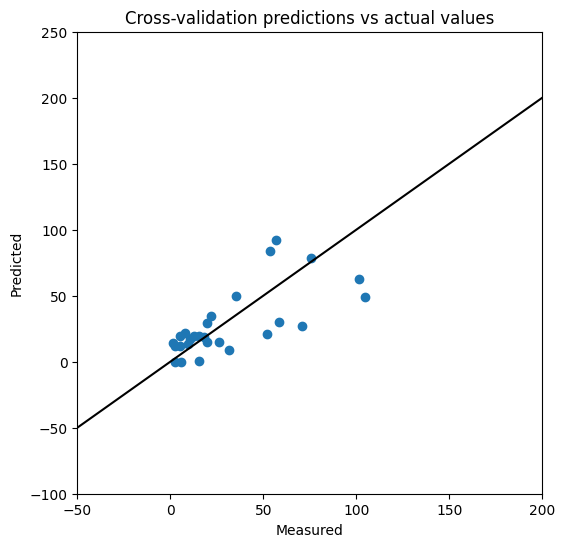

In [9]:
X = data_A[INPUT_VARS]
y = data_A[RESPONSE_VARS]

model = SVR()

# Tune hyperparameters with grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']}
grid = GridSearchCV(model, param_grid, refit=True, verbose=0, cv=5)

# Fit model
grid.fit(X, y.values.ravel())

# Get best estimator
model = grid.best_estimator_
scores = cross_validate(model, X, y.values.ravel(), cv=5, scoring=['r2', 'neg_mean_absolute_error'])

# Get cross-validation predictions
y_pred = cross_val_predict(model, X, y.values.ravel(), cv=5)
# Apply ln to all y_pred values
y_pred = np.log(1.0 + np.exp(y_pred))

# Plot cross-validation predictions vs actual values
plt.figure(figsize=(6,6))
plt.xlim(-50, 200)
plt.ylim(-100, 250)
# y=x line
plt.plot([-50, 200], [-50, 200], color='black')
plt.scatter(y, y_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Cross-validation predictions vs actual values')
plt.show()

In [10]:
# Dataframe with y_pred and y_true values
df_pred = pd.DataFrame()
df_pred['y_true'] = y.values.ravel()
df_pred['y_pred'] = y_pred
df_pred.index = data_A.index

# Calculate r2 and MAE for y_true and y_pred using sklearn
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate r2
r2 = r2_score(df_pred['y_true'], df_pred['y_pred'])
# Calculate MAE
mae = mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])

print(r2, mae)

0.45967029343378174 16.512799199365364
